<a href="https://colab.research.google.com/github/hurryhurchand/ProjetNLP/blob/main/ProjectClassificationDocumentsBBC_HurryHurchand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color=#9900cc>Etape 0 : Extraction de données</font>

##<font color=#000099>0.1 Importer les données</font>

In [ ]:
import pandas as pd
import numpy as np
import glob             # Utilisation de glob pour télécharger des fichier multiples 

In [ ]:
# Définir les noms des fichiers 
sports = ["athletics","cricket","football","rugby","tennis"]

# Définir la path pour retrouver les fichiers
mon_repertoire = "/content/drive/MyDrive" # path du  fichier qui contient /bbcsport-fulltext/bbcsport/
subpath = mon_repertoire + "/bbcsport-fulltext/bbcsport/"

# Création du dataframe
df = pd.DataFrame(columns=["Text","Category"])

# Lire chaque fichier se trouvant dans les fichiers de chaque fichier sport
%time
n = 0
for sport in sports:
  path = subpath + sport + "/*.txt"
  for file in glob.glob(path):
    f = open(file, "r", errors='replace')
    list1 =  f.readlines()
    phrase = ""
    for i in list1:
      phrase += i
    df.loc[n,"Text"] = phrase.replace("\n"," ")
    df.loc[n,"Category"] = sport
    n += 1
    f.close()


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


#<font color=#9900cc>Étape 1 : EDA</font>

##<font color=#000099>1.1 Afficher un échantillon aléatoire des données</font>

In [ ]:
df.sample(n=20)

,Text,Category
479,Chelsea 3-0 Portsmouth Didier Drogba scored t...,football
645,Davenport hits out at Wimbledon World number ...,tennis
618,Scotland 18-10 Italy Six Chris Paterson penal...,rugby
579,South Africa sweep top awards South Africa's ...,rugby
254,Sociedad set to rescue Mladenovic Rangers are...,football
253,Bosvelt optimistic over new deal Manchester C...,football
252,Time to get tough on friendlies? For an inter...,football
214,Bangladesh delighted at Test win Bangladeshi ...,cricket
527,Wales make two changes for France Wales coach...,rugby
363,Solskjaer raises hopes of return Manchester U...,football


##<font color=#000099>1.2 Taille du dataframe

In [ ]:
print("Nombre d'enregistrements :{}\nNombre de features : {}".format(df.shape[0],df.shape[1]))

Nombre d'enregistrements :737
Nombre de features : 2


##<font color=#000099>1.3 Vérifier la présence de doublons

In [ ]:
print("Nombre d'entrées en doublons = ",df[df.duplicated(subset=['Text','Category'])].shape[0])

Nombre d'entrées en doublons =  10


##<font color=#000099>1.3.1 Observation :
Il y en a 10 documents dans le corpus original qui sont repétées

## <font color=#000099>1.4 Vérifier la présence des données manquantes

In [ ]:
df.isnull().sum()

Text        0
Category    0
dtype: int64

##<font color=#000099> 1.4.1 Observation :
Il n'y a pas de données manquantes

## <font color=#000099>1.5 Vérifier la distribution des classes

In [ ]:
df_cible = pd.DataFrame(df.groupby('Category').count())
df_cible.rename(columns = {"Text":"Nmbre de documents"},inplace=True)
df_cible["%"] = df_cible["Nmbre de documents"].map(lambda x:round(x/df.shape[0]*100,2))
df_cible


,Nmbre de documents,%
Category,,
athletics,101,13.70
cricket,124,16.82
football,265,35.96
rugby,147,19.95
tennis,100,13.57


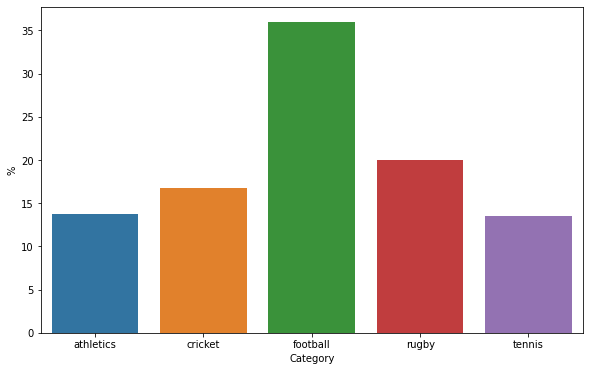

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
golden_ratio = (1+math.sqrt(5))/2   # Pour un visuel plaisant
width = 6
plt.figure(figsize=(width*golden_ratio,width))
sns.barplot(data=df_cible,x=df_cible.index,y="%")

# <font color=#000099>1.5.1 Observations</font>
1. Les classes dans la cible ne sont pas balancées
2. La classe "Football" est représentée environs 2 fois plus de fois que les autres catégories
3. Les catégories athletics, cricket,rugby et tennis ont une présence comparable en nombre

# <font color=#9900cc>2.0 Etape prétraitements</font>
1. Eliminer les doublons
2. Balancer les classes

#<font color=#000099>2.0.1 : Eliminer les doublons

In [ ]:
df.drop_duplicates(subset=["Text","Category"],keep="last",inplace=True)
print("Nombre d'enregistrements après supréssions des doublons:",df.shape[0])

Nombre d'enregistrements après supréssions des doublons: 727


#<font color=#000099> 2.0.2 Balancer les classes
Stratégie : Utiliser la stratégie de undersampling. Supprimer aléatoirement la moitié des enregistrements dans la classe soccer.

Justification : 
1. L'autre stratégie c'est la technique SMOTE, qui consiste à créer des enregistrements artificiels pour les classes sous représentées. Ici, on n'aura pas d'autres choix que de repétées des textes, qui peut occasionner un overfitting, car on va avoir environ 80% de données repétées

2. Enlever aléatoirement environ 130 enregistrements dans une base de donnes contenant 727 (18%) est considéré comme plus raisonnable comparé  à la stratégie en 1.

In [ ]:
# Liste aléatoire des enregistrements sur football  à supprimer
import random
df0 = df.copy()
football_index = [i for i in set(df0.index) if df0.loc[i,"Category"]=="football"]
random.shuffle(football_index)                            # ceci est une méthode inplace
football = football_index[130:]                           # garde l'index des items qui sont enlever
df1 = df.drop(labels=football,axis=0)
df = df1.copy()
df["Category"].value_counts()


rugby        146
football     130
cricket      121
athletics     99
tennis        99
Name: Category, dtype: int64

In [ ]:
df_balan_gp = pd.DataFrame(df.groupby('Category').count())
df_balan_gp.rename(columns={"Text":"Nombre d'enregistrements"},inplace=True)
sum = df_balan_gp["Nombre d'enregistrements"].sum()
df_balan_gp["%"] = df_balan_gp.iloc[:,0].map(lambda x:round(x/sum*100,2))
df_balan_gp


,Nombre d'enregistrements,%
Category,,
athletics,99,16.64
cricket,121,20.34
football,130,21.85
rugby,146,24.54
tennis,99,16.64


Text(0.5, 1.0, "Nombre d'enregistrements par classe après balancement")

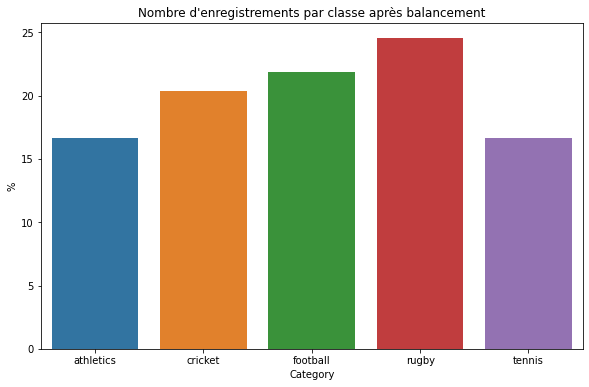

In [ ]:
plt.figure(figsize=(width*golden_ratio,width))
sns.barplot(data=df_balan_gp,x=df_balan_gp.index,y="%")
plt.title("Nombre d'enregistrements par classe après balancement")

In [ ]:
df["Category"].unique().tolist()

['athletics', 'cricket', 'football', 'rugby', 'tennis']

## <font color=#000099>2.1 Visualisation des termes pertinents : Word Cloud
##<font color="green"> Identification des stopwords pour le contexte

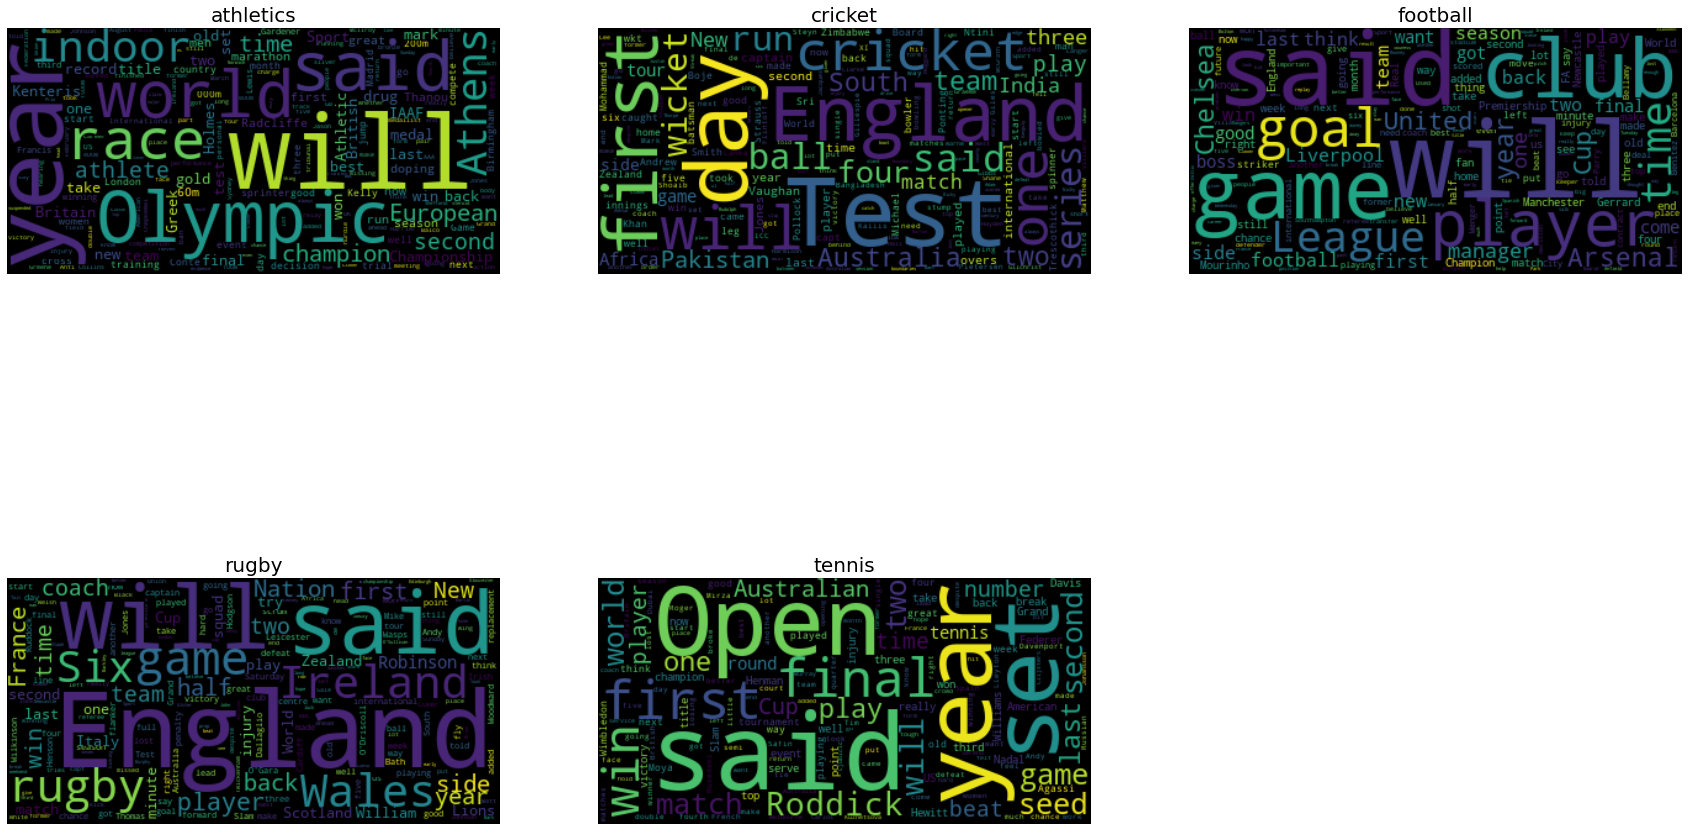

In [ ]:
from wordcloud import WordCloud

j = 0
w = 30
plt.figure(figsize=(w,w/golden_ratio))
liste_sports = df["Category"].unique().tolist()
for cat in liste_sports:
  df_text = df[df["Category"]==cat]
  text = ""
  for i in range(0,df_text.shape[0]):
    text = text + df_text.iloc[i,0]

  nuage = WordCloud(collocations = False, background_color ='black').generate(text)

  j = j + 1
  plt.subplot(2,3,j)
  plt.imshow(nuage, interpolation='bilinear')
  plt.title(cat,fontsize=20)
  plt.axis("off")
plt.show()

  
  


##<font color=#000099>Observation
1. Pour les contexte étudié il y a des stopwords qui pourraient ne pas figurer dans la liste de stopwords (on utilise pour ce projet celui disponible sur scikit learn)

2. Les stopwords identifiés sonts:

(a) will

(b) said

(c) play

(d) player

## <font color=#9900cc> 3.0 Etape Transformations</font>

# <font color=#000099>3.1 Encodage des séries catégorielles

##<font color=#000099> 3.1.1 Encodage cible : Category - Type nominal
### Stratégie - Label Encoder


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["category_id"] = le.fit_transform(df["Category"])
pd.crosstab(df["category_id"],df["Category"])

Category,athletics,cricket,football,rugby,tennis
category_id,,,,,
0,99,0,0,0,0
1,0,121,0,0,0
2,0,0,130,0,0
3,0,0,0,146,0
4,0,0,0,0,99


<Figure size 698.991x432 with 0 Axes>

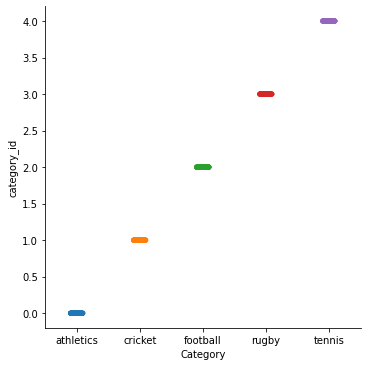

In [ ]:
plt.figure(figsize=(width*golden_ratio,width))
sns.catplot(data=df,x='Category',y='category_id')

## <font color=#000099>3.2 Feature Extraction
##<font color=#000099>3.2.1 Tokenisation et Vectorisation avec CountVectorizer 

In [ ]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
# Ajouter stopwords
nouveau_stopwords = {"will","play","player","said"}

stop_words_list= text.ENGLISH_STOP_WORDS.union(nouveau_stopwords)

In [ ]:
cv = CountVectorizer(max_df=0.9,min_df=2,stop_words=stop_words_list)

In [ ]:
dtm=cv.fit_transform(df["Text"])

## <font color=#000099>3.3 Utilisation de Latent Dirichlet Allocation pour une première analyse des regroupements

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
LDA = LatentDirichletAllocation(n_components=10,random_state=0)

In [ ]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# Cette partie du code a été pris du lien suivant
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

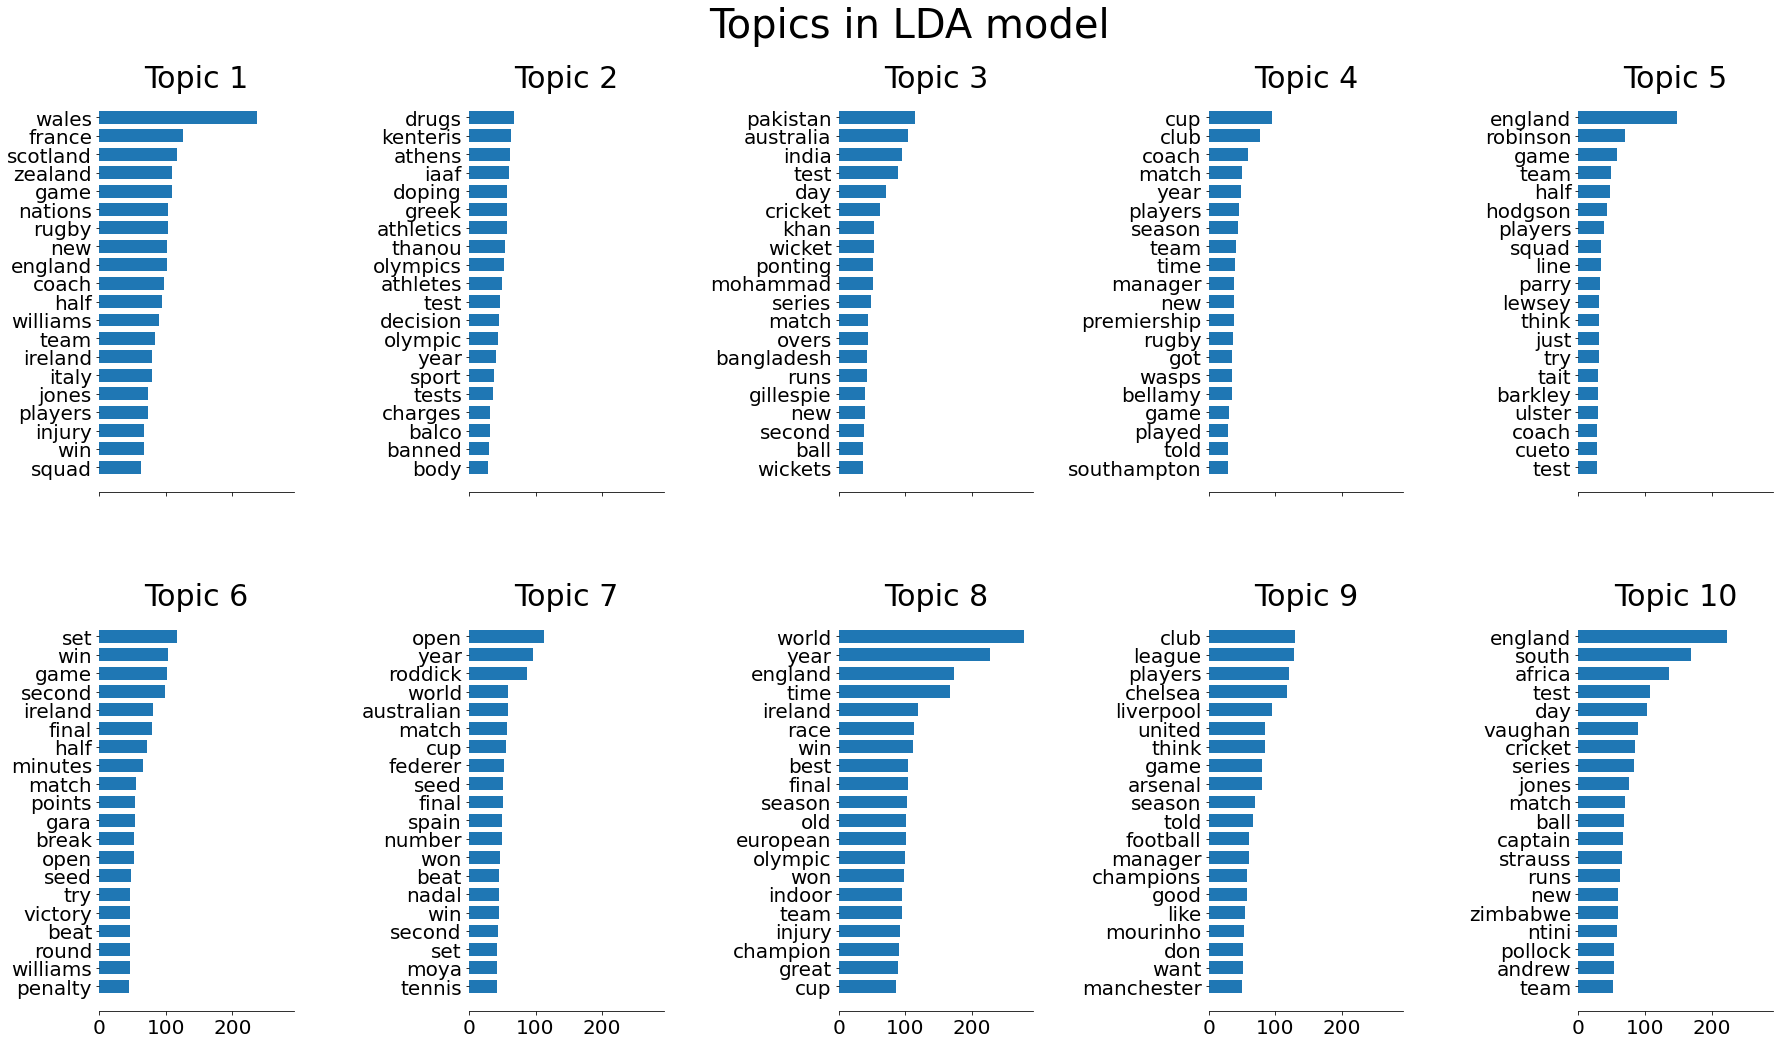

In [ ]:
tf_feature_names = cv.get_feature_names()
n_top_words = 20
plot_top_words(LDA, tf_feature_names, n_top_words, 'Topics in LDA model')

##<font color=#000099> Observation 2 : 
A. Le Latent Dirichlet Allocation (LDA), nous permet d'identifier certains clusters par thème. On doit déviner le thème en se basant sur notre connaissance du domaine. Certains catégories n'étaient pas facile à identifier ou n'étaient pas directement lié à la catégorie sport (par exemple Topic 2 parle essentiellement de dopage)

Selon les regroupements

1. Topic 1: Rugby
2. Topic 2: Athlétisme ou Dopage
3. Topic 3: Cricket
4. Topic 4: Football ou Rugby
5. Topic 5: Pas clair
6. Topic 6 : Pas clair
7. Topic 7: Tennis
8. Topic 8:Pas clair
9. Topic 9:Soccer
10. Topic 10: Cricket


## <font color=#000099>Observation 3:</font>
1. Le cricket et apparaît dans une plus grande majorité de thème. On suppose qu'il sera le plus facile à prédire comme catégorie
2. Le plus difficile vont peut-être être l'athlétisme et le Tennis car il n'apparaissent que une fois chacun.

## <font color=#000099>3.4 Utilisation de TFIDF (Avec n_gram) 
### <font color=#000099>+ Ajouter des stopwords identifié pour le contexte à l'étude

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(min_df=5, norm='l2', ngram_range=(1, 4), stop_words=stop_words_list)


features = tfidf.fit_transform(df['Text']).toarray()


labels = df.category_id


In [ ]:
features.shape

(595, 4590)

## <font color=#9900cc>4.0 Etape Développement de modèles</font>
## <font color=#000099>Creer un pipeline avec plusieurs modèles</font>
1. Decision Tree
2. Naive - Bayes
3. RandomForest
4. Logistic
5. Neural Network


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# Construire un pipeline pour les modeles

models = {"DT":DecisionTreeClassifier(random_state=0),
          "RFC":RandomForestClassifier(n_estimators=2000, max_depth=10, random_state=0),
          "Bayes": MultinomialNB(),
          "Logistic": LogisticRegression(random_state=0),
          "Neural Network":MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=0,max_iter=10000)}

In [ ]:
nfold = 5  # Crossvalidation ( 80-20 avec 5 folds )
output = []


## <font color=#000099>4.1. Phase Training et Evaluation
## <font color=#000099> Metrique utilisée : F1-score

In [ ]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
for nom,model in models.items():
  t0 = time()
  
##
  f1 = cross_val_score(model, features, labels, scoring='f1_macro', cv=nfold)
  #Split 
  X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0,shuffle=True)

# Apprentissage
  model.fit(X_train, y_train)
  
# Faire predictions
  y_pred_proba = model.predict_proba(X_test)
  y_pred = model.predict(X_test)
  print("Nom modèle\n",nom,classification_report(y_test, y_pred))
 
##
  [output.append((nom,fscore.mean(),time()-t0)) for fscore in f1]


Nom modèle
 DT               precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.88      0.88      0.88        34
           2       0.83      0.91      0.87        47
           3       0.89      0.94      0.92        52
           4       0.96      0.69      0.80        32

    accuracy                           0.87       197
   macro avg       0.87      0.85      0.86       197
weighted avg       0.87      0.87      0.87       197

Nom modèle
 RFC               precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.97      0.97      0.97        34
           2       0.92      0.96      0.94        47
           3       1.00      0.94      0.97        52
           4       1.00      0.97      0.98        32

    accuracy                           0.96       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.96      0.96   

In [ ]:
df_x_v = pd.DataFrame(output,columns=["Modele","F1_score","Temps(secondes)"])

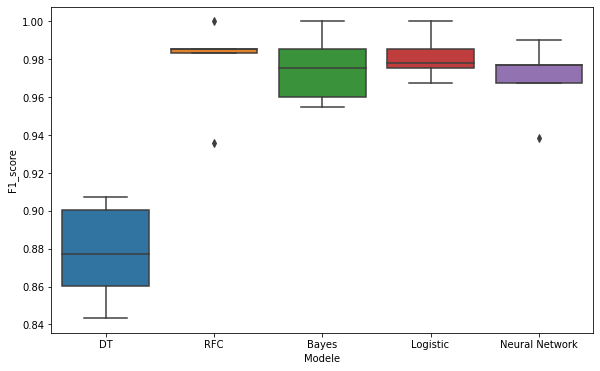

In [ ]:
plt.figure(figsize=(width*golden_ratio,width))
sns.boxplot(x='Modele', y='F1_score', data=df_x_v,orient="v")



In [ ]:
df_moyenne = df_x_v.groupby(['Modele']).mean()
df_moyenne

,F1_score,Temps(secondes)
Modele,,
Bayes,0.975167,0.116261
DT,0.877800,0.732071
Logistic,0.981412,4.698066
Neural Network,0.970026,10.927026
RFC,0.978004,32.756874


## <font color=#9900cc> 5.0 Etape Evaluation performance (métriques ML et temps de training)</font>

Text(0.5, 1.0, 'Comparaisons de F1 score et temps de training pour les différents modèles')

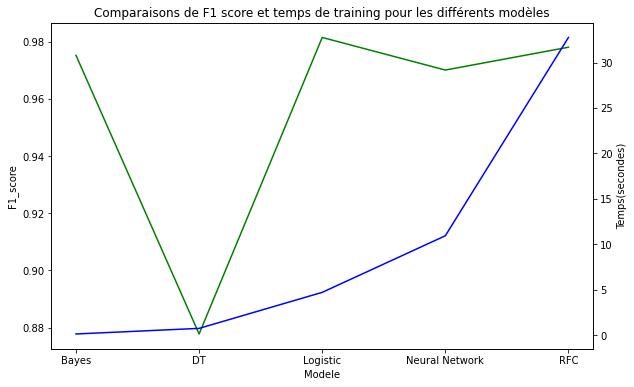

In [ ]:
plt.figure(figsize=(golden_ratio*width,width))
sns.lineplot(data=df_moyenne.F1_score, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_moyenne["Temps(secondes)"],color="b", ax=ax2)
plt.title("Comparaisons de F1 score et temps de training pour les différents modèles")

# <font color=#9900cc>6.0 Un exemple</font>

In [ ]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0,shuffle=True)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)



Text(0.5, 1.0, 'Matrice de confusion pour Regression Logistique')

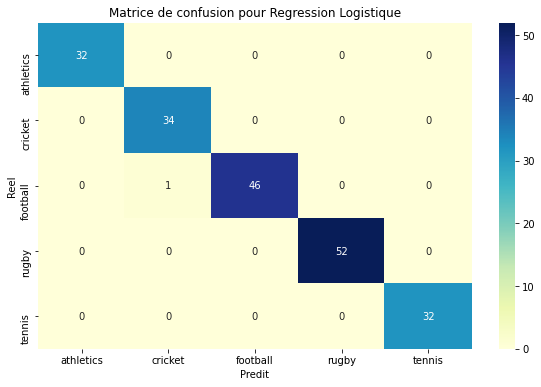

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize=(golden_ratio*width,width))

classes = ["athletics","cricket","football","rugby","tennis"]

matr = confusion_matrix(y_test, y_pred)
sns.heatmap(matr,annot=True,xticklabels=classes,yticklabels=classes,cmap="YlGnBu")

plt.ylabel('Reel')
plt.xlabel('Predit')
plt.title("Matrice de confusion pour Regression Logistique")




In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      1.00      0.99        34
           2       1.00      0.98      0.99        47
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        32

    accuracy                           0.99       197
   macro avg       0.99      1.00      0.99       197
weighted avg       1.00      0.99      0.99       197

